<a href="https://colab.research.google.com/github/dssp-ethz/DSSP-Illustrations/blob/main/Discrete_Fourier_Transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Notebook designed by Nicolas Menet in collaboration with Guy Revach.*

# Discrete Fourier Transform

The following code uses SciPy to compute the discrete fourier transform as introduced in the lecture notes on page 72 (as of 2020). You may play around with the values in the time domain as well as the signal length and plot the results.

In [1]:
import ipywidgets as widgets
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
%matplotlib inline
#-------------------------------------------------------------------------------

#Important Stuff
############################################################################
def compute_dft(fG):
  return [np.round(v,2) for v in fft(fG)] #computes DFT (rounding to 2 decimal places) as FFT (fast fourier transform)
############################################################################

fG = []
FG = []
def update_parameters(f):
  global fG, FG
  time = np.arange(0,2*np.pi,np.pi/6)

  if f == 'matched sinusoidal':
    fG = np.sin(time).tolist()

  elif f == 'unmatched sinusoidal':
    fG = np.sin(1.5*time).tolist()
  
  elif f == 'matched sinusoidal squared':
    fG = (np.sin(time)**2).tolist()
  elif f == '10 5 3 9 3 10':
    fG = [10, 5, 3, 9, 3, 10]

  FG = compute_dft(fG)
  print("F = ", list(FG))

  #global fG, FG
  #try:
  #  fG = [int(s) for s in f.split()]
  #  FG = compute_dft(fG)
  #  print("F = ", list(FG))
  #except:
  #  pass #catches bad input

widgets.interact(update_parameters, f=['matched sinusoidal', 'unmatched sinusoidal', 'matched sinusoidal squared', '10 5 3 9 3 10'],);

def illustrate():
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
  ax1.set_title('time domain')
  ax1.set_xlabel('$k$', fontsize=14)
  ax1.set_ylabel('$abs(f[k]])$', fontsize=14)
  ax1.stem(range(len(fG)), np.abs(fG))

  ax2.set_title('frequency domain')
  ax2.set_xlabel('$n$', fontsize=14)
  ax2.set_ylabel('$abs(f[n])$', fontsize=14)
  ax2.stem(range(len(FG)), np.abs(FG))

interactive(children=(Dropdown(description='f', options=('matched sinusoidal', 'unmatched sinusoidal', 'matche…

Try out the discrete fourier transform with different values (and different signal lengths). The graphs are plotted below for illustration.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


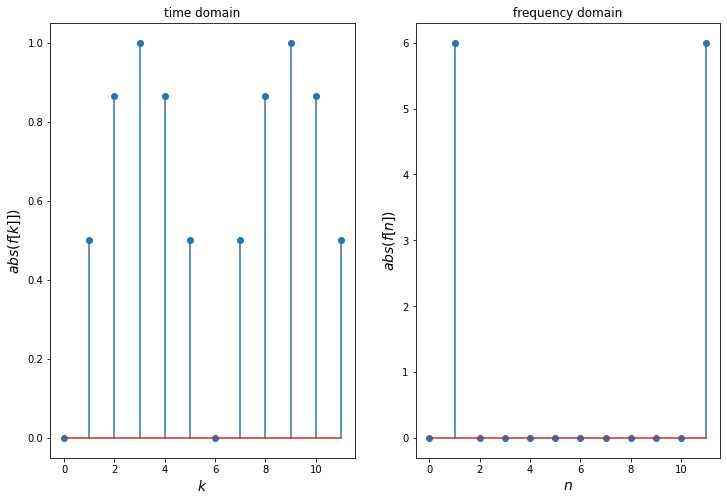

In [2]:
illustrate()

# Fast Fourier Transform

We wish to compute the discrete fourier transform (DFT) of a signal $f[k]$ which we assume has length $N$. We know the DFT to be given by
$$F[n] = F(\alpha^n) = \sum\limits_{k=0}^{N-1} f[k] \alpha^{-kn}$$
Computing the DFT for $n \in \{0,\ldots,N-1\}$ thus runs in $\mathcal{O}(N^2)$.

The Cooley-Tukey FFT (page 77 as of 2020) improves the runtime of the DFT to $\mathcal{O}(\log(N) \cdot N)$. We shall quickly motivate its construction. <br>
Assuming $N = N_1 \cdot N_2$ we can decompose $F(z)$ into $F(z) = \sum\limits_{k_1=0}^{N_1-1} F_{k_1} (z^{N_1}) z^{-k_1}$ and $F_{k_1} (z) = \sum\limits_{k_2=0}^{N_2-1} f[N_1 k_2 + k_1] z^{-k_2}$. We can use the same decomposition for the DFT with $n = N_2 n_1 + n_2$ (substituting $z = \alpha^n$) to get
$$F[N_2 n_1 + n_2] = \sum\limits_{k_1=0}^{N_1-1} \left[ F_{k_1} ((\alpha^{N_1})^{n_2}) \alpha^{-k_1 n_2} \right] (\alpha^{N_2})^{-k_1 n_1}$$

Thus instead of calculating 1 DFT of size $N = N_1 \cdot N_2$ we can calculate $N_1$ DFT's of size $N_2$ cutting the runtime from $N^2 = N_1^2 \cdot N_2^2$ to $N_1 \cdot N_2^2$. We can perform this decomposition repeatedly until we only have to compute very small DFT's. Of course there are additional operations that need to be done to combine the results, but the main savings leading to a runtime of $\mathcal{O}(\log(N)\cdot N)$ should be clear.

We may implement the aforementioned decomposition of the DFT in a 5 step procedure as describe in the lecture notes on page 78 (as of 2020). The steps are:



1.   Write the data row after row into a matrix with $N_2$ rows and $N_1$ columns.
2.   Replace every column by its DFT with $\alpha_1 = \alpha^N_1$.
3.   Multiply every element of the matrix with  $\alpha^{- k_1 n_2}$ where $n_2$ indicates the row and $k_1$ the column (0 indexed).
4.   Replace every row by its DFT with $\alpha_2 = \alpha^{N_2}$.
5.   Read data column after column.

In [9]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#-------------------------------------------------------------------------------

#Important Stuff
################################################################################
def dft(f, alpha):
  F = [0]*len(f)
  for n in range(len(F)):
    for k in range(len(f)):
      F[n] += f[k] * alpha**(- k * n)
  return F

def step_by_step_dft(f, N_1, N_2, alpha):
  #convert to table 
    f_table = np.resize(f, (N_2, N_1))

    f_table_columnDFT = np.zeros(f_table.shape, dtype = 'complex_')

    for c in range(N_1):
      f_table_columnDFT[:,c] = dft(f_table[:,c], alpha**(N_1))
      
    f_table_columnDFT_adjusted = np.zeros(f_table_columnDFT.shape, dtype = 'complex_')
    for k_1 in range(N_1):
      for n_2 in range(N_2):
        f_table_columnDFT_adjusted[n_2, k_1] = f_table_columnDFT[n_2, k_1] * alpha**(- k_1 * n_2)

    f_tableDFT = np.zeros(f_table_columnDFT_adjusted.shape, dtype = 'complex_')
    for r in range(N_2):
      f_tableDFT[r,:] = dft(f_table_columnDFT_adjusted[r,:], alpha**(N_2))

    f_DFT = []
    for column in range(N_1):
      for row in range(N_2):
        f_DFT.append(f_tableDFT[row, column])

    f_DFT = np.array(f_DFT)

    return (f_table, f_table_columnDFT, f_table_columnDFT_adjusted, f_tableDFT, f_DFT)
################################################################################

def update(N_1, f):
  try:
    f = np.array([int(s) for s in f.split()])
    f.reshape(f.size,1)
    alpha = np.exp(2j*np.pi/f.size)
    if f.size % N_1 != 0:
      raise #exception thrown since reshaping is impossible
    N_2 = f.size//N_1

    (f_table, f_table_columnDFT, f_table_columnDFT_adjusted, f_tableDFT, f_DFT) = step_by_step_dft(f, N_1, N_2, alpha)


    print(np.round(f, 2))
    print("\nStep 1")
    print(np.round(f_table, 2))
    print("\nStep 2")
    print(np.round(f_table_columnDFT, 2))
    print("\nStep 3")
    print(np.round(f_table_columnDFT_adjusted, 2))
    print("\nStep 4")
    print(np.round(f_tableDFT, 2))
    print("\nStep 5")
    print(np.round(f_DFT, 2))
    print("\nF = ", np.reshape(np.round(f_DFT, 2),(1,f_DFT.size)).tolist()[0])
  except:
    pass #catches bad input as well as invalid dimensions
widgets.interact(update, N_1 = widgets.IntSlider(min=1, max=5, value=2), f="10 5 3 9 3 10");

interactive(children=(IntSlider(value=2, description='N_1', max=5, min=1), Text(value='10 5 3 9 3 10', descrip…

Above you can see the 5 steps of the FFT decomposition perform on an adjustable signal. You may also change the layout of the decomposition by changing the parameter $N_1$.